<a href="https://colab.research.google.com/github/Dhaneesh02/Project_1/blob/visual/mfcc_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.utils.vis_utils import plot_model

In [1]:
import os
from glob import glob
import pickle
import numpy as np
import pandas as pd

### Plot imports ###
from IPython.display import Image
import matplotlib.pyplot as plt

### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder

### Warning ###
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X_train = pickle.load(open('drive/My Drive/FYP/Pickle/[RAVDESS][MEL_SPECT][X_train].p', 'rb'))
y_train = pickle.load(open('drive/My Drive/FYP/Pickle/[RAVDESS][MEL_SPECT][y_train].p', 'rb'))
y_test = pickle.load(open('drive/My Drive/FYP/Pickle/[RAVDESS][MEL_SPECT][y_test].p', 'rb'))
X_test = pickle.load(open('drive/My Drive/FYP/Pickle/[RAVDESS][MEL_SPECT][X_test].p', 'rb'))

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3225, 5, 128, 128)
(3225,)
(807, 5, 128, 128)
(807,)


In [5]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = np_utils.to_categorical(lb.transform(np.ravel(y_test)))

In [6]:
# Reshape for convolution
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , X_test.shape[2], X_test.shape[3], 1)

In [7]:
X_train.shape[1:]

(5, 128, 128, 1)

In [8]:
K.clear_session()

input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                                           
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_MELSPECT (InputLayer)  [(None, 5, 128, 128, 1)]  0        
                                                                 
 Conv_1_MELSPECT (TimeDistri  (None, 5, 128, 128, 64)  640       
 buted)                                                          
                                                                 
 BatchNorm_1_MELSPECT (TimeD  (None, 5, 128, 128, 64)  256       
 istributed)                                                     
                                                                 
 Activ_1_MELSPECT (TimeDistr  (None, 5, 128, 128, 64)  0         
 ibuted)                                                         
                                                                 
 MaxPool_1_MELSPECT (TimeDis  (None, 5, 64, 64, 64)    0         
 tributed)                                                   

In [9]:
# Compile model
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint('CNN_LSTM_Model.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save,tf.keras.callbacks.CSVLogger('drive/My Drive/FYP/Pickle/mel_source_history.csv')])

Epoch 1/100
51/51 [==============================] - 43s 515ms/step - loss: 1.9463 - accuracy: 0.1839 - val_loss: 2.0727 - val_accuracy: 0.1710
Epoch 2/100
51/51 [==============================] - 23s 457ms/step - loss: 1.8359 - accuracy: 0.2509 - val_loss: 1.9304 - val_accuracy: 0.2131
Epoch 3/100
51/51 [==============================] - 23s 459ms/step - loss: 1.7145 - accuracy: 0.2983 - val_loss: 2.0645 - val_accuracy: 0.2144
Epoch 4/100
51/51 [==============================] - 24s 463ms/step - loss: 1.6457 - accuracy: 0.3383 - val_loss: 1.8360 - val_accuracy: 0.2825
Epoch 5/100
51/51 [==============================] - 24s 466ms/step - loss: 1.5880 - accuracy: 0.3659 - val_loss: 1.9614 - val_accuracy: 0.2627
Epoch 6/100
51/51 [==============================] - 24s 469ms/step - loss: 1.5600 - accuracy: 0.3684 - val_loss: 1.8613 - val_accuracy: 0.2862
Epoch 7/100
51/51 [==============================] - 24s 467ms/step - loss: 1.5284 - accuracy: 0.3991 - val_loss: 1.6722 - val_accuracy:

In [10]:
model.evaluate(X_test,y_test)

26/26 [==============================] - 3s 84ms/step - loss: 0.8929 - accuracy: 0.7224


[0.8928874731063843, 0.7224287390708923]

In [11]:
y_pred=model.predict(X_test)
y_classes = y_pred.argmax(axis=-1)

In [12]:
np.unique(y_classes)

array([0, 1, 2, 3, 4, 5, 6])

In [13]:
my_dict={}

In [15]:
# np.vectorize(my_dict.get)(a)

In [ ]:
model.save('drive/My Drive/Pickle/[CNN-LSTM]M.h5')
model.save_weights('drive/My Drive/Pickle/[CNN-LSTM]W.h5')

In [ ]:
#  unaugmented_model = tf.keras.models.load_model('/content/drive/MyDrive/Pickle/unaugmented[CNN-LSTM]M.h5')
#  unaugmented_model.load_weights('/content/drive/MyDrive/Pickle/unaugmented[CNN-LSTM]M.h5')

In [16]:
# loss, acc = new_model.evaluate(x_test, y_test, verbose=0)
# print(f"test accuracy {acc*100}")
history={}
history["history"] = pd.read_csv('/content/drive/MyDrive/FYP/Pickle/source_history.csv')
history["history"].head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.176434,1.943628,0.137546,2.310542
1,1,0.216124,1.866385,0.142503,2.304680
2,2,0.288682,1.766965,0.237918,1.937099
3,3,0.308217,1.716241,0.325898,1.773858
4,4,0.334264,1.650814,0.363073,1.764403


In [17]:
history

{'history':     epoch  accuracy      loss  val_accuracy  val_loss
 0       0  0.176434  1.943628      0.137546  2.310542
 1       1  0.216124  1.866385      0.142503  2.304680
 2       2  0.288682  1.766965      0.237918  1.937099
 3       3  0.308217  1.716241      0.325898  1.773858
 4       4  0.334264  1.650814      0.363073  1.764403
 ..    ...       ...       ...           ...       ...
 95     95  0.878450  0.335211      0.690211  1.128962
 96     96  0.883101  0.320538      0.684015  1.118421
 97     97  0.878140  0.326981      0.722429  0.938620
 98     98  0.889922  0.311682      0.473358  2.482491
 99     99  0.885581  0.304403      0.587361  1.571177
 
 [100 rows x 5 columns]}

Text(0, 0.5, 'Accuracy')

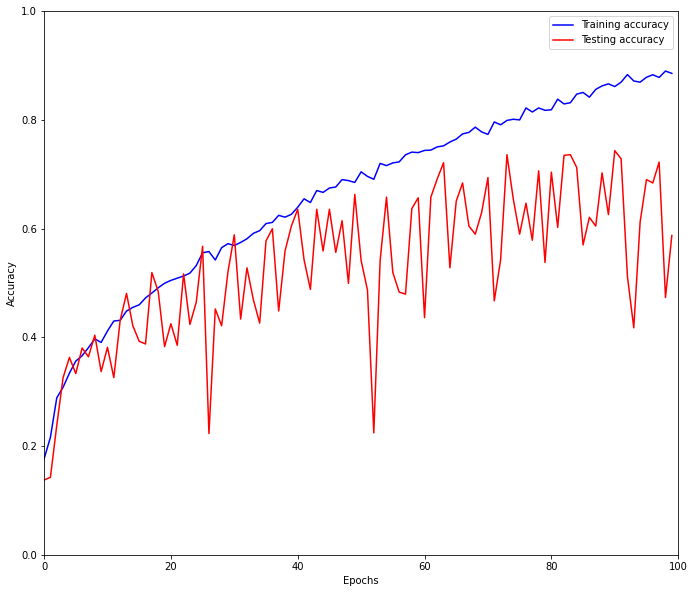

In [18]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(history['history']['accuracy'],'-b')
plt.plot(history['history']['val_accuracy'],'r')
plt.legend(['Training accuracy','Testing accuracy'])
plt.axis([0, 100, 0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')



In [19]:
history={}
history["history"] = pd.read_csv('/content/drive/MyDrive/FYP/Pickle/unaugmented_history.csv')
history["history"].head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.670698,0.844424,0.371747,2.340874
1,1,0.665116,0.876073,0.178439,3.659123
2,2,0.684651,0.848129,0.334572,2.660065
3,3,0.675349,0.850737,0.446097,2.100447
4,4,0.671628,0.815418,0.401487,1.940121


Text(0, 0.5, 'Accuracy')

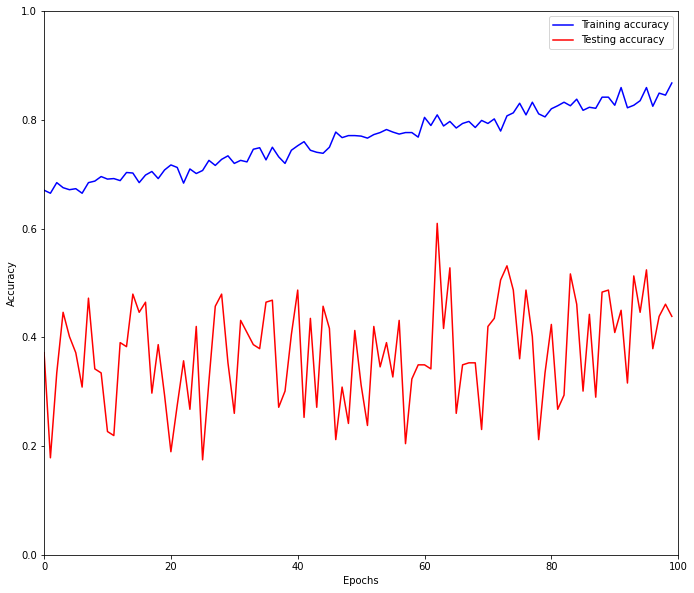

In [20]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(history['history']['accuracy'],'-b')
plt.plot(history['history']['val_accuracy'],'r')
plt.legend(['Training accuracy','Testing accuracy'])
plt.axis([0, 100, 0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [21]:
history={}
history["history"] = pd.read_csv('/content/drive/MyDrive/FYP/Pickle/mel_source_history.csv')
history["history"].head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.183876,1.946318,0.171004,2.072664
1,1,0.250853,1.835925,0.213135,1.930380
2,2,0.298295,1.714530,0.214374,2.064523
3,3,0.338295,1.645723,0.282528,1.836003
4,4,0.365891,1.588006,0.262701,1.961444


Text(0, 0.5, 'Accuracy')

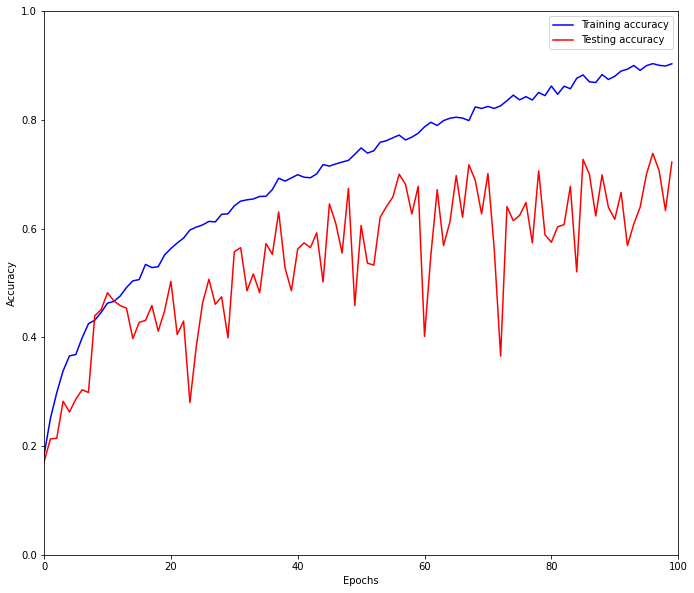

In [22]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(history['history']['accuracy'],'-b')
plt.plot(history['history']['val_accuracy'],'r')
plt.legend(['Training accuracy','Testing accuracy'])
plt.axis([0, 100, 0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')